# Importando Bibliotecas

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# Carregando Dataset

In [225]:
df = pd.read_csv("Data/VendasSupermercadosCDI.csv", sep=";")
df.head()

,Date,VendasSupermercados,CDI
0,2010-01-01,76.39,0.66
1,2010-02-01,73.95,0.59
2,2010-03-01,81.69,0.76
3,2010-04-01,77.91,0.66
4,2010-05-01,78.66,0.75


O dataset possui três colunas 
- **Date:** Representa da data das vendas no supermercado
- **VendasSupermercados:** Vendas do supermercado naquele dia
- **CDI:** Valor do CDI (Certificado de Depósito Interbancário) naquele dia

# Engenharia de Variáveis

In [226]:
# função que converte a feature Date para datetime
def convert_date_column(df, column_name):
    df[column_name] = pd.to_datetime(df[column_name])
    return df

convert_date_column(df, 'Date')

# função que cria uma coluna de trimestres e as vendas por trimestre
def add_trimestre_column(df, date_column, vendas_column):
    df['Trimestre'] = df[date_column].dt.to_period("Q")
    df['VendasPorTrimestre'] = df.groupby('Trimestre')[vendas_column].transform('sum')
    return df

df = add_trimestre_column(df, 'Date', 'VendasSupermercados')

# função que cria uma coluna com a média do cdi no trimestre
def add_media_cdi_trimestral(df, date_column, cdi_column):
    df['MediaCDITrimestral'] = df.groupby('Trimestre')[cdi_column].transform('mean')
    return df

df = add_media_cdi_trimestral(df, 'Trimestre', 'CDI')

df['Trimestre'] = df['Trimestre'].astype(str)
df.head()

,Date,VendasSupermercados,CDI,Trimestre,VendasPorTrimestre,MediaCDITrimestral
0,2010-01-01,76.39,0.66,2010Q1,232.03,0.670000
1,2010-02-01,73.95,0.59,2010Q1,232.03,0.670000
2,2010-03-01,81.69,0.76,2010Q1,232.03,0.670000
3,2010-04-01,77.91,0.66,2010Q2,233.47,0.733333
4,2010-05-01,78.66,0.75,2010Q2,233.47,0.733333


In [227]:
print(df.Date.max())
print(df.Date.min())

2023-08-01 00:00:00
2010-01-01 00:00:00


Vemos que o intervalo entre a primeira e a última data de vendas do dataset é de aproximadamente 13 anos e meio

In [228]:
# dividindo os dados em treino e teste 
def split_df(df):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
    return df_train, df_test

df_train, df_test = split_df(df)

def column_order(df, column):
    # Ordenando o DataFrame pela coluna especificada
    df = df.sort_values(by=column)
    return df

df_train = column_order(df_train, 'Trimestre')



Dividindo os dados logo no ínicio da análise para evitar vazamento e simular o ambiente real

# Análise Exploratória de Dados

In [229]:
df_train.columns

Index(['Date', 'VendasSupermercados', 'CDI', 'Trimestre', 'VendasPorTrimestre',
       'MediaCDITrimestral'],
      dtype='object')

In [230]:
# Analisando as dimensões do dataset
df_train.shape

(131, 6)

O dataset possui poucas linhas e colunas, então buscaremos criar mais variáveis para melhorar o modelo final

In [231]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131 entries, 2 to 163
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 131 non-null    datetime64[ns]
 1   VendasSupermercados  131 non-null    float64       
 2   CDI                  131 non-null    float64       
 3   Trimestre            131 non-null    object        
 4   VendasPorTrimestre   131 non-null    float64       
 5   MediaCDITrimestral   131 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 7.2+ KB


As features não possuem valores ausentes. As **VendasSupermercados** e **CDI** estão num formato correto, porém a **Date** precisar ser transformado para datetime

In [232]:
df_train.describe()

,Date,VendasSupermercados,CDI,VendasPorTrimestre,MediaCDITrimestral
count,131,131.000000,131.000000,131.000000,131.000000
mean,2016-10-17 07:41:40.763358720,93.128779,0.734351,278.675267,0.732723
min,2010-01-01 00:00:00,73.950000,0.130000,208.100000,0.156667
25%,2013-07-16 12:00:00,88.170000,0.535000,266.325000,0.525000
50%,2016-11-01 00:00:00,91.700000,0.770000,278.220000,0.763333
75%,2020-01-16 12:00:00,97.635000,0.950000,296.820000,0.960000
max,2023-08-01 00:00:00,118.910000,1.210000,327.600000,1.143333
std,NaN,8.778967,0.278662,23.579878,0.271503


Vemos que a média e mediana das **VendasSupermercados** estão próximas, isso pode indicar uma distribuição mais simétrica dos dados e provavelmente pouca presença de outliers. Além disso, o desvio padrão do **CDI** está em quase 40% da média do **CDI** o que indica uma variabilidade considerável

In [233]:
df_train.nunique(axis=0)

Date                   131
VendasSupermercados    127
CDI                     67
Trimestre               55
VendasPorTrimestre      54
MediaCDITrimestral      51
dtype: int64

Percebemos que não há datas repitidas, porém alguns dias com o mesmo número de vendas da mesma forma do CDI

In [234]:
df_train.VendasSupermercados.value_counts()

VendasSupermercados
91.54     2
89.43     2
91.20     2
91.70     2
81.69     1
         ..
92.38     1
88.09     1
94.73     1
89.01     1
104.75    1
Name: count, Length: 127, dtype: int64

In [235]:
df_train.CDI.value_counts()

CDI
0.54    6
1.11    5
0.59    4
0.84    4
0.49    4
       ..
1.00    1
1.06    1
0.60    1
0.98    1
1.14    1
Name: count, Length: 67, dtype: int64

isso confirma o que falamos acima e vemos quais os valores com repeticões e quais os mais repitidos

In [236]:
df_train.duplicated().sum()

0

Não temos nenhuma linha duplicada

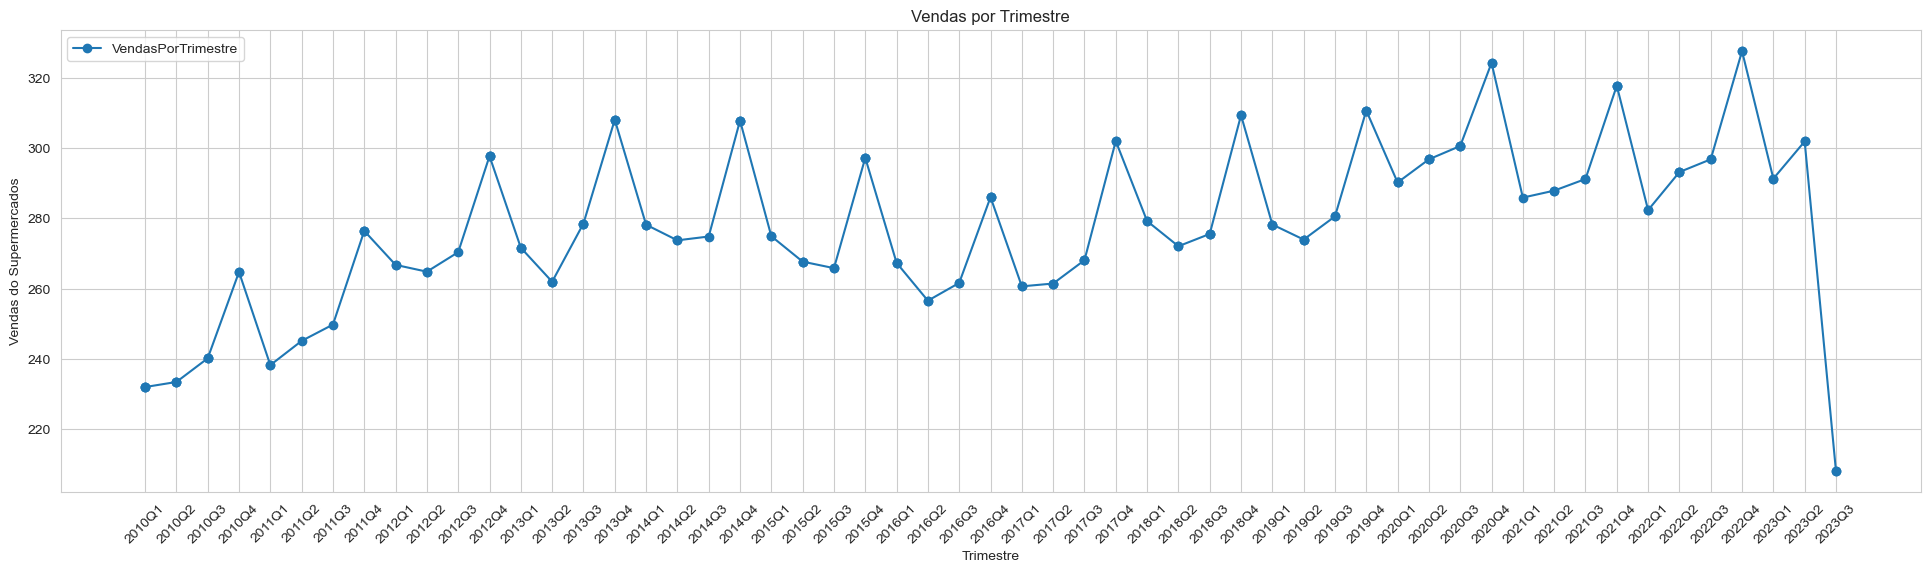

In [237]:
df_train = df_train.sort_values(by='Trimestre')

plt.figure(figsize=(24, 6))
plt.plot(df_train['Trimestre'], df_train['VendasPorTrimestre'], label='VendasPorTrimestre', marker='o')
plt.title('Vendas por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Vendas do Supermercados')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

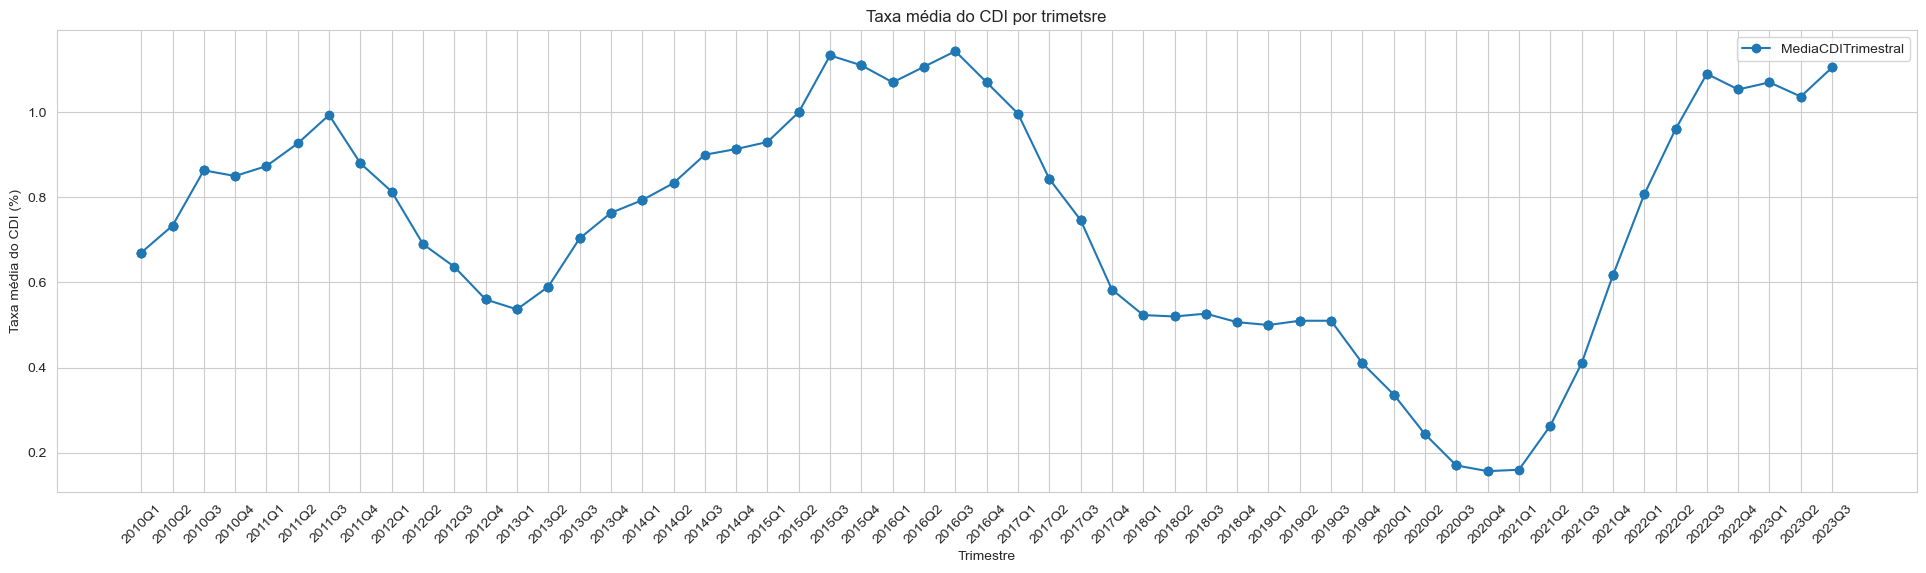

In [238]:
plt.figure(figsize=(24, 6))
plt.plot(df_train['Trimestre'], df_train['MediaCDITrimestral'], label='MediaCDITrimestral', marker='o')
plt.title('Taxa média do CDI por trimetsre')
plt.xlabel('Trimestre')
plt.ylabel('Taxa média do CDI (%)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

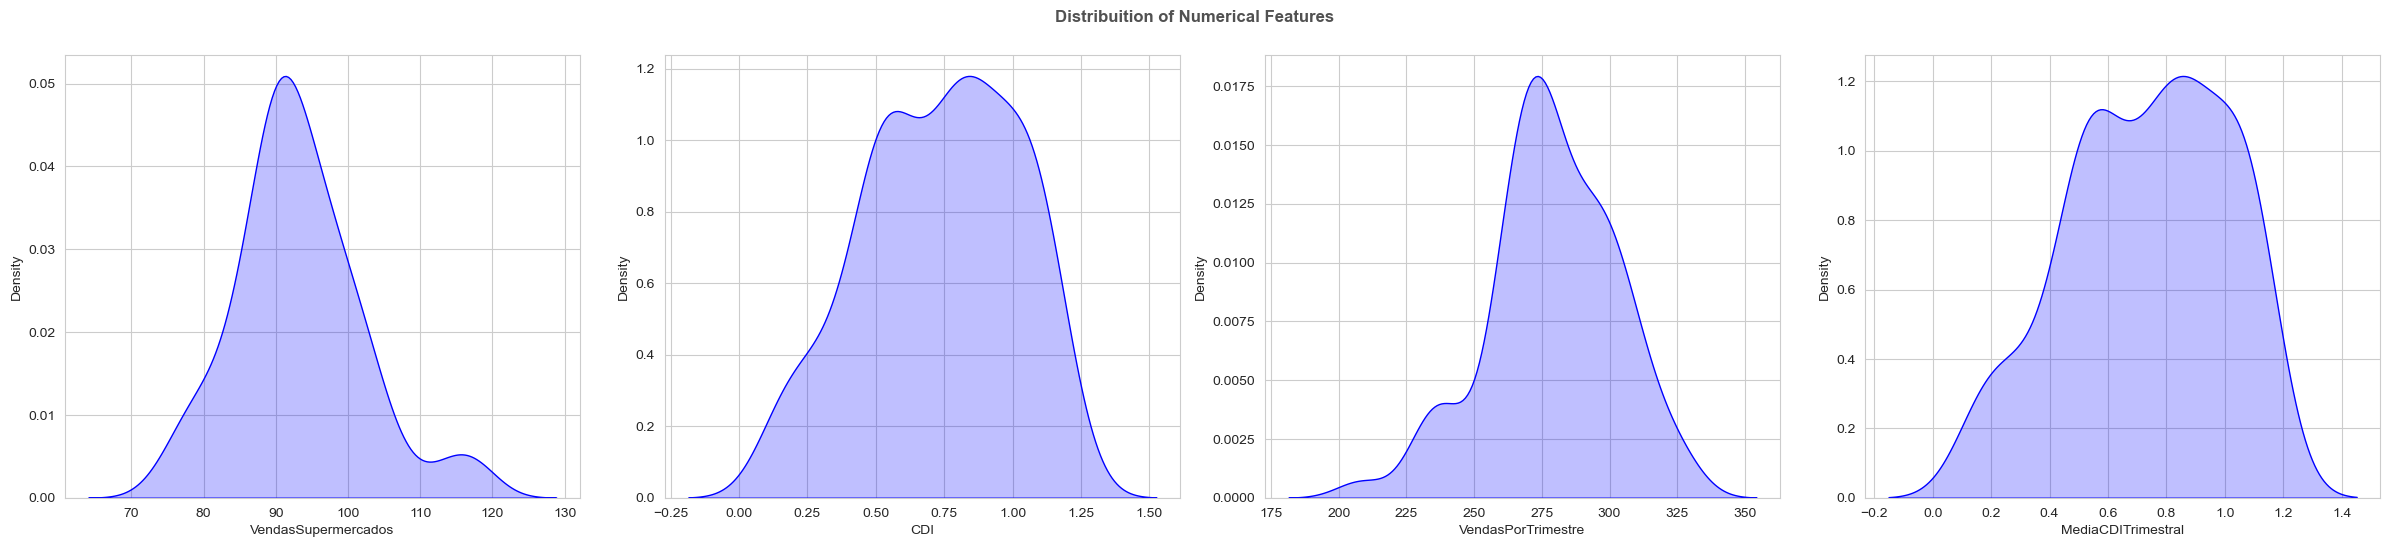

In [239]:
numerical_features = ['VendasSupermercados', 'CDI', 'VendasPorTrimestre', 'MediaCDITrimestral']

plt.figure(figsize=(24, 10))
plt.suptitle('Distribuition of Numerical Features', fontsize=12, fontweight='bold', alpha=0.8, y=1.)
for i in range(len(numerical_features)):
    plt.subplot(2, 4, i+1)
    sns.kdeplot(x=df_train[numerical_features[i]], shade=True, color='b')
    plt.xlabel(numerical_features[i])
    plt.tight_layout()

# Modelo